In [48]:
from treeswift import read_tree_newick
from niemads import DisjointSet
from queue import Queue
import numpy as np
import pandas as pd

## Leer un árbol y preprocesarlo

In [49]:
def get_tree(path):
    f = open(path, "r")
    tree = read_tree_newick(f.read())
    
    # hacer el arbol binario
    tree.resolve_polytomies() 
    tree.suppress_unifurcations()
    leaves = set()
    for node in tree.traverse_postorder():
    
        if node.edge_length is None:
            node.edge_length = 0
        node.is_cut = False
        
        if node.is_leaf():
            leaves.add(str(node))
    return (tree, leaves)

## Utils

In [50]:
def get_leaves_cluster(node):
    cluster = list()
    cluster_object = list()
    daughters = Queue()
    daughters.put(node)
    
    while not daughters.empty():
        daughter = daughters.get()
        if daughter.is_cut:
            continue
        
        daughter.is_cut = True
        
        daughter.Bl = 0
        daughter.Br = 0
        
        if daughter.is_leaf():
            cluster.append(str(daughter))
        else:
            for c in daughter.children:
                daughters.put(c)
    return cluster

In [51]:
def write_result(path, clusters):
    outfile = open(path, 'w')
    
    outfile.write('SequenceName\tClusterNumber\n')
    
    c = 1
    
    for cluster in clusters:
        if len(cluster) == 1:
            # todos los clusters de tamaño 1 se les asigna como
            # numero de cluster -1
            outfile.write('%s\t-1\n' % list(cluster)[0])
        else:
            for hoja in cluster:
                outfile.write('%s\t%d\n' % (hoja,c))
            c+=1
    outfile.close()

In [52]:
def compare_results(path_impl, path_paper):
    output_imp = open(path_impl, 'r')
    
    first = True
    
    hashmap = {}
    for line in output_imp:
        if first:
            first = False
            continue
        words = line.split()
        hashmap[int(words[0])] = int(words[1])
        
    output_paper = open(path_paper, 'r')
    
    acc = 0
    total = 0
    first = True
    for line in output_paper:
        if first:
            first = False
            continue
        total+=1
        words = line.split()
        
        if hashmap[int(words[0])] == int(words[1]):
            acc+=1
    print(acc/total)

## Algoritmo 1: Max-diameter min-cut partitioning

In [53]:
def min_cut_max_diameter(path, threshold):
    tree, leaves = get_tree(path)
    clusters = list()
    for node in tree.traverse_postorder():
        
        if node.is_leaf():
            node.Bl = 0
            node.Br = 0
            continue
        if node.is_cut:
            continue
        
        #only 2 children
        children = list(node.children)
        
        #tree is binary
        if children[0].is_cut:
            node.Bl = 0
            if children[1].is_cut:
                get_leaves_cluster(node)
                continue
        else:
            node.Bl = max(children[0].Bl, children[0].Br) + children[0].edge_length
        
        
        if children[1].is_cut:
            node.Br = 0
        else:
            node.Br = max(children[1].Bl, children[1].Br) + children[1].edge_length
              
        # check threshold
        if node.Bl + node.Br > threshold:
            # cut longer one
            if node.Bl > node.Br:
                new_cluster = get_leaves_cluster(children[0])
                node.Bl = 0
            else:
                new_cluster = get_leaves_cluster(children[1])
                node.Br = 0
        
            if len(new_cluster) > 0:
                clusters.append(new_cluster)
                for c in new_cluster:
                    leaves.remove(c)
                    
    if len(leaves) > 0:
        clusters.append(list(leaves))
    return clusters   

In [7]:
write_result("./outputs/diamater.txt",min_cut_max_diameter("./data/99_otus_unannotated.tree", 0.1))

In [8]:
compare_results("./outputs/diamater.txt", "./outputs/paper_diameter.txt")

1.0


##  Algoritmo 2: Sum-length min-cut partitioning

In [9]:
def min_cut_max_sum(path, threshold):
    tree, leaves = get_tree(path)
    clusters = list()
    for node in tree.traverse_postorder():
        
        if node.is_leaf():
            node.Bl = 0
            node.Br = 0
            continue
        if node.is_cut:
            continue
        
        #only 2 children
        children = list(node.children)
        
        #tree is binary
        if children[0].is_cut:
            node.Bl = 0
            if children[1].is_cut:
                get_leaves_cluster(node)
                continue
        else:
            node.Bl = children[0].Bl + children[0].Br + children[0].edge_length
        
        
        if children[1].is_cut:
            node.Br = 0
        else:
            node.Br = children[1].Bl + children[1].Br + children[1].edge_length
              
        # check threshold
        if node.Bl + node.Br > threshold:
            # cut longer one
            if node.Bl > node.Br:
                new_cluster = get_leaves_cluster(children[0])
                node.Bl = 0
            else:
                new_cluster = get_leaves_cluster(children[1])
                node.Br = 0
        
            if len(new_cluster) > 0:
                clusters.append(new_cluster)
                for c in new_cluster:
                    leaves.remove(c)
                    
    if len(leaves) > 0:
        clusters.append(list(leaves))
    return clusters

In [10]:
write_result("./outputs/sum_length.txt",min_cut_max_sum("./data/99_otus_unannotated.tree", 0.1))

In [11]:
compare_results("./outputs/sum_length.txt", "./outputs/max_sum_paper.txt")

1.0


## Algoritmo 3: Single-Linkage

In [12]:
def single_linkage(path, threshold):
    tree, leaves = get_tree(path)
    clusters = list()
    
    # buscar en el actual sub-arbol las distancias minimas a sus hojas
    for node in tree.traverse_postorder():
        if node.is_leaf():
            # guardar la distancia minima y el id de la hoja
            node.minBelow = (0, node.label) 
        else:
            node.minBelow = min((c.minBelow[0]+c.edge_length,c.minBelow[1]) for c in node.children)
            
    # buscar la distancia minima del actual nodo 
    #a una hoja que no este en el sub-arbol
    
    for node in tree.traverse_preorder():
        node.minAbove = (float('inf'), None)
        
        if node.is_root():
            continue
        
        #buscar por sus hermanas
        for c in node.parent.children:
            if c != node:
                if node.edge_length + c.edge_length + c.minBelow[0] < node.minAbove[0]:
                    node.minAbove = (node.edge_length + c.edge_length + c.minBelow[0] , c.minBelow[1])
                    
        # buscar por la madre
        if not c.parent.is_root():
            if node.edge_length + node.parent.minAbove[0] < node.minAbove[0]:
                node.minAbove = (node.edge_length + node.parent.minAbove[0], node.parent.minAbove[1])
                
    # buscar los clusters
    
    for node in tree.traverse_postorder():
        if node.is_leaf():
            continue
        
        children = node.children
        
        left_distance = children[0].minBelow[0] + children[0].edge_length
        right_distance = children[1].minBelow[0] + children[1].edge_length
        above_distance = node.minAbove[0]
        
        if left_distance + right_distance > threshold and left_distance + above_distance > threshold:
            cluster = get_leaves_cluster((children[0]))
            
            if len(cluster) > 0:
                clusters.append(cluster)
                for c in cluster:
                    leaves.remove(c)
        
        if left_distance + right_distance > threshold and right_distance + above_distance > threshold:
            cluster = get_leaves_cluster((children[1]))
            
            if len(cluster) > 0:
                clusters.append(cluster)
                for c in cluster:
                    leaves.remove(c)
        
        if left_distance + above_distance > threshold and right_distance + above_distance > threshold:
            cluster = get_leaves_cluster(node)
            if len(cluster) > 0:
                clusters.append(cluster)
                for c in cluster:
                    leaves.remove(c)
                    
    if len(leaves) > 0:
        clusters.append(list(leaves))
    return clusters

In [13]:
write_result("./outputs/single_linkage.txt",single_linkage("./data/99_otus_unannotated.tree", 0.1))

In [14]:
compare_results("./outputs/single_linkage.txt", "./outputs/single_linkage_paper.txt")

1.0


# Greengenes Database Tests

In [54]:
threshold = [0.015, 0.03, 0.045, 0.06, 0.09, 0.12, 0.15]

## Generación de datos generales

In [23]:
columns = ["threshold","singletons", "total #clusters", "max. cluster size"]
table = []
for t in threshold:
    clusters = min_cut_max_diameter("./data/99_otus_unannotated.tree", t)
    num_singletons = 0
    max_cluster_size = 0
    for cluster in clusters:
        max_cluster_size = max(len(cluster), max_cluster_size)
        if(len(cluster) == 1):
            num_singletons+=1
    
    table.append([t, num_singletons, len(clusters), max_cluster_size])
    

table = np.array(table)


In [24]:
df = pd.DataFrame(data=table, columns=columns)
df

,threshold,singletons,total #clusters,max. cluster size
0,0.015,86387.0,123456.0,47.0
1,0.030,42510.0,77263.0,96.0
2,0.045,24795.0,54068.0,171.0
3,0.060,15257.0,39809.0,305.0
4,0.090,6396.0,23631.0,540.0
5,0.120,3003.0,15052.0,808.0
6,0.150,1525.0,10112.0,1209.0


## Cluster diversity

In [55]:
def get_aligns():
    
    answer = dict()
    
    fasta_file = open('./data/99_otus.fasta', 'r') 

    while True: 
        # Get next line from file 
        id_seq = fasta_file.readline() 
        if not id_seq:
            break
        id_seq = id_seq[1:-1:1]
        
        sequence = fasta_file.readline()
        answer[id_seq] = sequence

    fasta_file.close() 
    return answer

In [62]:
def get_hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("las secuencias deben tener igual longitud")
    mm = 0
    sup = 0
    
    for el1, el2 in zip(seq1, seq2):
        if el1 == '-' and el2 == '-':
            continue
        sup+=1
        if el1 != el2:
            mm+=1
    return mm*1.0/sup

In [57]:
def get_diversity(clusters, path,type=1, mapping=None ):
    total_clusters = len(clusters)
    tree, leaves = get_tree(path)
    if type == 1:
        mapping = tree.label_to_node()
    ans = 0.0
    for cluster in clusters:
        sum_distances = 0.0
        for leaf1 in cluster:
            for leaf2 in cluster:
                if leaf1 == leaf2:
                    continue
                else:
                    if type == 1:
                        sum_distances+=tree.distance_between(mapping[leaf1], mapping[leaf2])
                    else:
                        sum_distances+=get_hamming_distance(mapping[leaf1], mapping[leaf2])
        sum_distances/=float(len(cluster))
        ans+=sum_distances
    
    diversity = ans/float(len(leaves))
    return diversity

### Por tamaño de camino

In [28]:
x_num_clusters = []
y_diversity = []
for t in threshold:
    clusters = min_cut_max_diameter("./data/99_otus_unannotated.tree", t)
    x_num_clusters.append(len(clusters))
    y_diversity.append(get_diversity(clusters, "./data/99_otus_unannotated.tree"))
    print(y_diversity)


[0.0034172728244792837]
[0.0034172728244792837, 0.009236990494159053]
[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147]
[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147, 0.020423735288374895]
[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147, 0.020423735288374895, 0.031077718658176823]
[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147, 0.020423735288374895, 0.031077718658176823, 0.04150775815961433]
[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147, 0.020423735288374895, 0.031077718658176823, 0.04150775815961433, 0.051923570254061406]


In [29]:
print(x_num_clusters)

[123456, 77263, 54068, 39809, 23631, 15052, 10112]


In [30]:
print(y_diversity)

[0.0034172728244792837, 0.009236990494159053, 0.014887186286003147, 0.020423735288374895, 0.031077718658176823, 0.04150775815961433, 0.051923570254061406]


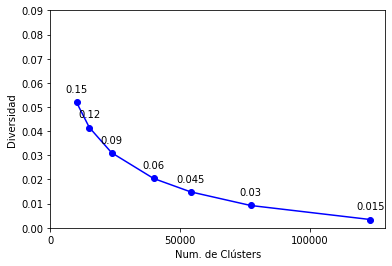

In [40]:
import matplotlib.pyplot as plt
# 'bo-' means blue color, round points, solid lines
plt.plot(x_num_clusters,y_diversity,'bo-')
c = 0
# zip joins x and y coordinates in pairs
for x,y in zip(x_num_clusters,y_diversity):

    plt.annotate(threshold[c], # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    c+=1
plt.xticks(np.arange(0,150000,50000))
plt.yticks(np.arange(0,0.1,0.01))
plt.xlabel("Num. de Clústers")
plt.ylabel("Diversidad")
plt.show()

### Por distancia de hamming

In [65]:
fasta_file = open('./data/99_otus.fasta', 'r') 

line = fasta_file.readline() 
print(line)

>1110860



In [66]:
line = fasta_file.readline() 
print(line[:200])

------------------------------------------------------------------------------------------------------------TCCGGTT-GA--T-CC-T-G-CCGG-AC-CC-G-AC-T-GC--TAT-C--A-GA-GTGG--GA---C-T--AAGCCA-T-GC-G-AGT-TA-


In [67]:
len(line)

7683

In [40]:
line = fasta_file.readline() 
len(line)

9

In [41]:
line = line[1:-1:1]

In [42]:
len(line)

7

In [30]:
line

'1110360'

In [58]:
alignments = get_aligns()

In [63]:
x_num_clusters = []
y_diversity = []
for t in threshold:
    clusters = min_cut_max_diameter("./data/99_otus_unannotated.tree", t)
    x_num_clusters.append(len(clusters))
    y_diversity.append(get_diversity(clusters, "./data/99_otus_unannotated.tree", type=2, mapping=alignments))
    print(y_diversity)

[0.017842309972081423]
[0.017842309972081423, 0.031766922343621135]
[0.017842309972081423, 0.031766922343621135, 0.041368357643551026]
[0.017842309972081423, 0.031766922343621135, 0.041368357643551026, 0.04899320995790196]
[0.017842309972081423, 0.031766922343621135, 0.041368357643551026, 0.04899320995790196, 0.06059308973447253]
[0.017842309972081423, 0.031766922343621135, 0.041368357643551026, 0.04899320995790196, 0.06059308973447253, 0.06957876196918593]
[0.017842309972081423, 0.031766922343621135, 0.041368357643551026, 0.04899320995790196, 0.06059308973447253, 0.06957876196918593, 0.07701368097261797]


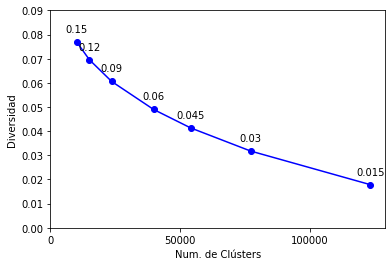

In [64]:
import matplotlib.pyplot as plt
# 'bo-' means blue color, round points, solid lines
plt.plot(x_num_clusters,y_diversity,'bo-')
c = 0
# zip joins x and y coordinates in pairs
for x,y in zip(x_num_clusters,y_diversity):

    plt.annotate(threshold[c], # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    c+=1
plt.xticks(np.arange(0,150000,50000))
plt.yticks(np.arange(0,0.1,0.01))
plt.xlabel("Num. de Clústers")
plt.ylabel("Diversidad")
plt.show()